<a href="https://colab.research.google.com/github/13333333333333/CS2040/blob/main/Project_NYC_Taxi_trip_duration_Learners_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project - Predictive Analytics: New York City Taxi Ride Duration Prediction**

## **Marks: 40**
---------------

## **Context**
---------------

New York City taxi rides form the core of the traffic in the city of New York. The many rides taken every day by New Yorkers in the busy city can give us a great idea of traffic times, road blockages, and so on. A typical taxi company faces a common problem of efficiently assigning the cabs to passengers so that the service is hassle-free. One of the main issues is predicting the duration of the current ride so it can predict when the cab will be free for the next trip. Here the data set contains various information regarding the taxi trips, its duration in New York City. We will apply different techniques here to get insights into the data and determine how different variables are dependent on the Trip Duration.

-----------------
## **Objective**
-----------------

- To Build a predictive model, for predicting the duration for the taxi ride. 
- Use Automated feature engineering to create new features

-----------------
## **Dataset**
-----------------

The ``trips`` table has the following fields
* ``id`` which uniquely identifies the trip
* ``vendor_id`` is the taxi cab company - in our case study we have data from three different cab companies
* ``pickup_datetime`` the time stamp for pickup
* ``dropoff_datetime`` the time stamp for drop-off
* ``passenger_count`` the number of passengers for the trip
* ``trip_distance`` total distance of the trip in miles 
* ``pickup_longitude`` the longitude for pickup
* ``pickup_latitude`` the latitude for pickup
* ``dropoff_longitude``the longitude of dropoff 
* ``dropoff_latitude`` the latitude of dropoff
* ``payment_type`` a numeric code signifying how the passenger paid for the trip. 1= Credit card 2= Cash 3= No charge 4= Dispute 5= Unknown 6= Voided
* ``trip_duration`` this is the duration we would like to predict using other fields 
* ``pickup_neighborhood`` a one or two letter id of the neighborhood where the trip started
* ``dropoff_neighborhood`` a one or two letter id of the neighborhood where the trip ended


#### **We will do the following steps:**
  * Install the dependencies
  * Load the data as pandas dataframe
  * Perform EDA on the dataset
  * Build features with Deep Feature Synthesis using the [featuretools](https://featuretools.com) package. We will start with simple features and incrementally improve the feature definitions and examine the accuracy of the system

****Uncomment the following code and run it to install the featuretools library****

In [ ]:
# Uncomment the code given below, and run the line of code to install featuretools library

!pip install featuretools==0.27.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 327 kB 7.3 MB/s 
     |████████████████████████████████| 281 kB 17.4 MB/s 
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


**Note:** If **!pip install featuretools** doesn't work, please install using the **anaconda prompt** by typing the following command in anaconda prompt
> `conda install -c conda-forge featuretools==0.27.0`




## **Import the necessary libraries**

In [ ]:
# Basic libraries of python for numeric and dataframe computations
import numpy as np                              
import pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt     

# Slightly advanced library for data visualization            
import seaborn as sns                          

# Featauretools for feature engineering
import featuretools as ft

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Importing gradient boosting regressor, to make prediction
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Importing primitives
from featuretools.primitives import (Minute, Hour, Day, Month,
                                     Weekday, IsWeekend, Count, Sum, Mean, Median, Std, Min, Max)

# Used to ignore the warning given as output of the code
import warnings
warnings.filterwarnings("ignore")

print(ft.__version__)
%load_ext autoreload
%autoreload 2

0.27.0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Set global random seed
np.random.seed(40)

# To preview first five rows. 
def preview(df, n=5):
    """return n rows that have fewest number of nulls"""
    order = df.isnull().sum(axis=1).sort_values().head(n).index
    return df.loc[order]

# To compute features using automated feature engineering. 
def compute_features(features, cutoff_time):
    # Shuffle so we don't see encoded features in the front or backs

    np.random.shuffle(features)
    feature_matrix = ft.calculate_feature_matrix(features,
                                                 cutoff_time=cutoff_time,
                                                 approximate='36d',
                                                 verbose=True)
    print("Finishing computing...")
    feature_matrix, features = ft.encode_features(feature_matrix, features,
                                                  to_encode=["pickup_neighborhood", "dropoff_neighborhood"],
                                                  include_unknown=False)
    return feature_matrix


# To generate train and test dataset
def get_train_test_fm(feature_matrix, percentage):
    nrows = feature_matrix.shape[0]
    head = int(nrows * percentage)
    tail = nrows-head
    X_train = feature_matrix.head(head)
    y_train = X_train['trip_duration']
    X_train = X_train.drop(['trip_duration'], axis=1)
    imp = SimpleImputer()
    X_train = imp.fit_transform(X_train)
    X_test = feature_matrix.tail(tail)
    y_test = X_test['trip_duration']
    X_test = X_test.drop(['trip_duration'], axis=1)
    X_test = imp.transform(X_test)

    return (X_train, y_train, X_test,y_test)



# To see the feature importance of variables in the final model
def feature_importances(model, feature_names, n=5):
    importances = model.feature_importances_
    zipped = sorted(zip(feature_names, importances), key=lambda x: -x[1])
    for i, f in enumerate(zipped[:n]):
        print("%d: Feature: %s, %.3f" % (i+1, f[0], f[1]))

### **Load the datasets**

In [ ]:
# If you are using Google Colab then while reading the files using 'pd.read_csv()', replace the location of CSV files with the exact location of the files in your drive folder. 
trips = pd.read_csv('trips.csv',
                        parse_dates=["pickup_datetime","dropoff_datetime"],
                        dtype={'vendor_id':"category"})
trips["payment_type"] = trips["payment_type"].apply(str)
trips = trips.dropna(axis=0, how='any', subset=['trip_duration'])

pickup_neighborhoods = pd.read_csv("pickup_neighborhoods.csv", encoding='utf-8')
dropoff_neighborhoods = pd.read_csv("dropoff_neighborhoods.csv", encoding='utf-8')

### **View the Datasets**

In [ ]:
preview(trips, 10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,0,2,2016-01-01 00:00:19,2016-01-01 00:06:31,3,1.32,-73.961258,40.796200,-73.950050,40.787312,2.0,372.0,AH,C
82981,86651,2,2016-01-17 08:01:20,2016-01-17 08:30:34,1,19.41,-73.788834,40.641750,-73.993362,40.726292,2.0,1754.0,G,H
82980,86650,1,2016-01-17 08:01:17,2016-01-17 08:05:45,1,0.60,-73.981834,40.736660,-73.983353,40.743809,1.0,268.0,R,AO
82979,86649,1,2016-01-17 08:00:56,2016-01-17 08:07:48,1,1.50,-73.954895,40.780186,-73.979858,40.790516,1.0,412.0,C,I
82978,86648,1,2016-01-17 07:58:47,2016-01-17 08:05:07,1,1.40,-73.982056,40.763332,-74.000656,40.757824,1.0,380.0,AR,P
82977,86647,2,2016-01-17 07:57:01,2016-01-17 08:03:39,1,1.78,-73.994873,40.745224,-73.985085,40.728077,2.0,398.0,AP,AT
82976,86646,2,2016-01-17 07:56:51,2016-01-17 07:59:50,6,0.75,-73.938873,40.791397,-73.947617,40.790466,2.0,179.0,J,C
82975,86645,2,2016-01-17 07:56:30,2016-01-17 08:09:20,5,3.45,-73.957481,40.770111,-74.000282,40.758610,1.0,770.0,K,P
82974,86644,2,2016-01-17 07:55:37,2016-01-17 08:06:29,1,3.08,-74.001579,40.727749,-73.971672,40.758041,1.0,652.0,AB,N
82973,86643,1,2016-01-17 07:55:05,2016-01-17 08:00:38,1,2.20,-73.972260,40.786221,-73.993912,40.756691,2.0,333.0,I,P


In [ ]:
# Drop the rows where at least one element is missing. 
trips=trips.dropna()

For the features used in the model the "**dropoff_datetime**" needs to be removed as this value would not be known for real-time prediction and you can basically take the difference between the pickup and dropoff time to find the duration.So, this will restrict our model to be **robust** and **reliable**. So, dropping this feature will help us to avoid **data leakage**.

Data leakage in machine learning occurs when the data used to train a machine learning algorithm contains information that the model is attempting to predict, resulting in unreliable and poor prediction outcomes after model deployment.

In [ ]:
trips. drop("dropoff_datetime", axis=1, inplace=True) 

### **Let's check the first five rows of the data**

In [ ]:
trips.head()

,id,vendor_id,pickup_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,0,2,2016-01-01 00:00:19,3,1.32,-73.961258,40.796200,-73.950050,40.787312,2.0,372.0,AH,C
1,1,2,2016-01-01 00:01:45,1,13.70,-73.956169,40.707756,-73.939949,40.839558,1.0,1553.0,Z,S
2,2,1,2016-01-01 00:01:47,2,5.30,-73.993103,40.752632,-73.953903,40.816540,2.0,1204.0,D,AL
3,3,2,2016-01-01 00:01:48,1,7.19,-73.983009,40.731419,-73.930969,40.808460,2.0,858.0,AT,J
4,4,1,2016-01-01 00:02:49,2,2.90,-74.004631,40.747234,-73.976395,40.777237,1.0,1076.0,AG,AV


Let's check the **info** of the data

In [ ]:
# Checking the info of the dataset
trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124462 entries, 0 to 124461
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    124462 non-null  int64         
 1   vendor_id             124462 non-null  category      
 2   pickup_datetime       124462 non-null  datetime64[ns]
 3   passenger_count       124462 non-null  int64         
 4   trip_distance         124462 non-null  float64       
 5   pickup_longitude      124462 non-null  float64       
 6   pickup_latitude       124462 non-null  float64       
 7   dropoff_longitude     124462 non-null  float64       
 8   dropoff_latitude      124462 non-null  float64       
 9   payment_type          124462 non-null  object        
 10  trip_duration         124462 non-null  float64       
 11  pickup_neighborhood   124462 non-null  object        
 12  dropoff_neighborhood  124462 non-null  object        
dtyp

- There are 974409 non null values in the dataset

### **Check the number of unique values in the dataset.**

In [ ]:
# Check the uniques values in each columns
trips.nunique()

id                      124462
vendor_id                    2
pickup_datetime         120224
passenger_count              7
trip_distance             2090
pickup_longitude         12958
pickup_latitude          26513
dropoff_longitude        15454
dropoff_latitude         30868
payment_type                 4
trip_duration             3367
pickup_neighborhood         49
dropoff_neighborhood        49
dtype: int64

- vendor_id has only 2 unique values, implies there are only 2 major taxi vendors are there. 
- Passenger count has 8 unique values and payment type have 4. 
- There are 49 neighborhood in the dataset, from where either a pickup or dropoff is happening. 

### **Question 1 : Check summary statistics of the dataset (1 Mark)**

In [ ]:
# Checking the descriptive stats of the data

trips.describe().T

,count,mean,std,min,25%,50%,75%,max
id,124462.0,64916.735461,37536.416253,0.000000,32379.250000,64945.500000,97365.750000,129959.000000
passenger_count,124462.0,1.677845,1.330972,0.000000,1.000000,1.000000,2.000000,6.000000
trip_distance,124462.0,2.701010,3.261636,0.000000,0.990000,1.600000,2.900000,32.300000
pickup_longitude,124462.0,-73.972617,0.036726,-74.029053,-73.990799,-73.980980,-73.966408,-73.770927
pickup_latitude,124462.0,40.752386,0.026931,40.631462,40.739826,40.755617,40.769001,40.849884
dropoff_longitude,124462.0,-73.972834,0.031038,-74.029625,-73.990158,-73.979080,-73.962753,-73.770020
dropoff_latitude,124462.0,40.753197,0.028812,40.630047,40.739136,40.755850,40.770481,40.849937
trip_duration,124462.0,743.926074,541.531157,0.000000,367.000000,601.000000,958.000000,3605.000000


**Write your answers here:_____**

### **Checking for the rows for which trip_distance is 0**

In [ ]:
# Chekcing the rows where trip distance is 0
trips[trips['trip_distance']==0]

,id,vendor_id,pickup_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
852,880,1,2016-01-01 02:15:56,1,0.0,-74.002586,40.750298,-74.002861,40.750446,2.0,21.0,AG,AG
1079,1116,1,2016-01-01 03:01:10,1,0.0,-73.987831,40.728558,-73.988747,40.727280,3.0,136.0,H,H
1408,1455,2,2016-01-01 04:09:43,1,0.0,-73.985893,40.763649,-73.985741,40.763672,2.0,65.0,AR,AR
1440,1488,1,2016-01-01 04:16:54,1,0.0,-74.014198,40.709988,-74.014198,40.709988,3.0,3.0,AU,AU
1510,1558,1,2016-01-01 04:36:03,1,0.0,-73.952507,40.817329,-73.952499,40.817322,2.0,13.0,AL,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123906,129387,1,2016-01-26 15:37:23,2,0.0,-73.782417,40.648815,-73.782394,40.648834,2.0,19.0,G,G
124091,129577,2,2016-01-26 16:34:06,1,0.0,-73.794685,40.667576,-73.794556,40.667515,4.0,99.0,G,G
124168,129654,2,2016-01-26 16:56:25,1,0.0,-73.783058,40.643856,-73.783081,40.643902,1.0,83.0,G,G
124422,129918,1,2016-01-26 18:00:56,1,0.0,-73.979179,40.784992,-73.979195,40.785004,3.0,4.0,I,I


- We can observe that, where trip distance is 0 trip duration is not 0, hence we can replace those values. 
- There are 3807 such rows

#### **Replacing the 0 values with median of the trip distance**

In [ ]:
trips['trip_distance']=trips['trip_distance'].replace(0,trips['trip_distance'].median())

In [ ]:
trips[trips['trip_distance']==0].count()

id                      0
vendor_id               0
pickup_datetime         0
passenger_count         0
trip_distance           0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
payment_type            0
trip_duration           0
pickup_neighborhood     0
dropoff_neighborhood    0
dtype: int64

#### **Checking for the rows for which trip_duration is 0**

In [ ]:
trips[trips['trip_duration']==0].head()

,id,vendor_id,pickup_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
44446,46325,1,2016-01-10 00:48:55,1,1.20,-73.968842,40.766972,-73.968842,40.766972,3.0,0.0,AK,AK
121544,126869,2,2016-01-26 00:07:47,6,4.35,-73.986694,40.739815,-73.956139,40.732872,1.0,0.0,R,Z


- We can observe that, where trip distance is 0 trip duration is not 0, hence we can replace those values. 

In [ ]:
trips['trip_duration']=trips['trip_duration'].replace(0,trips['trip_duration'].median())

In [ ]:
trips[trips['trip_duration']==0].count()

id                      0
vendor_id               0
pickup_datetime         0
passenger_count         0
trip_distance           0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
payment_type            0
trip_duration           0
pickup_neighborhood     0
dropoff_neighborhood    0
dtype: int64

## **Question 2: Univariate Analysis**

### **Question 2.1: Build histogram for numerical columns (1 Marks)**

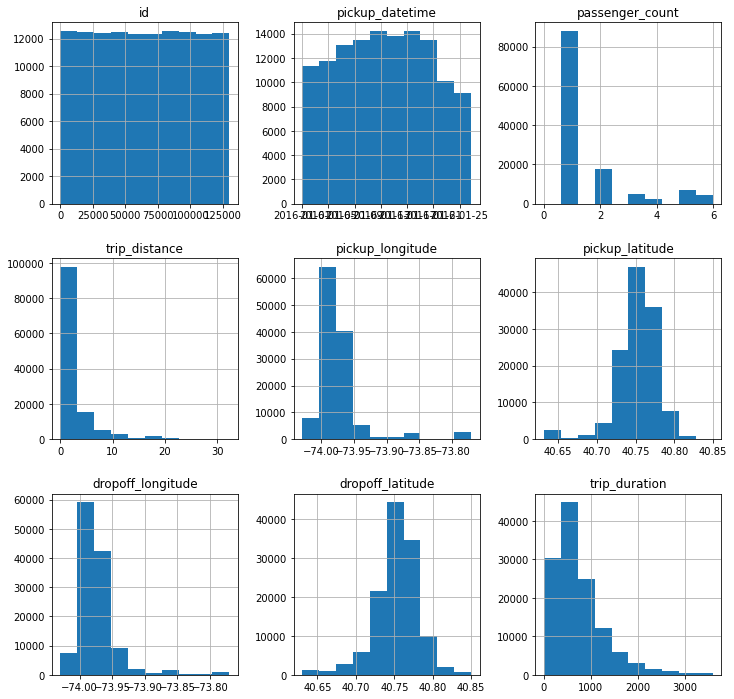

In [ ]:
trips.hist(figsize=(12,12))
plt.show()

**Write your answers here: Both the trip dist and trip duration are a bit right skewed.**

**Pickup_lattitude, pickup_longitude, dropoff_longitude and dropoff_lattitude follows a nearly normal distribution**

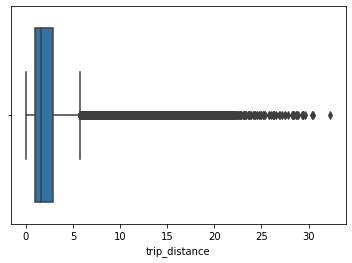

In [ ]:
sns.boxplot(trips['trip_distance'])
plt.show()

- We can see there is an extreme outlier in the dataset, we drop investigate it further

In [ ]:
trips[trips['trip_distance']>100]

,id,vendor_id,pickup_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood


- We can observe that, there are 2 observation>500, and there is a huge gap in the trip duration for them.
- Covering 501.4 distance in 141 sec, is not possible, it is better we can clip these values to 50. 

**Clipping the outliers of trip distance to 50**

In [ ]:
trips['trip_distance']=trips['trip_distance'].clip(trips['trip_distance'].min(),50)

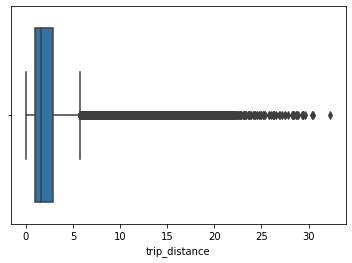

In [ ]:
sns.boxplot(trips['trip_distance'])
plt.show()

### **Question 2.2 Plotting countplot for Passenger_count (1 Marks)**

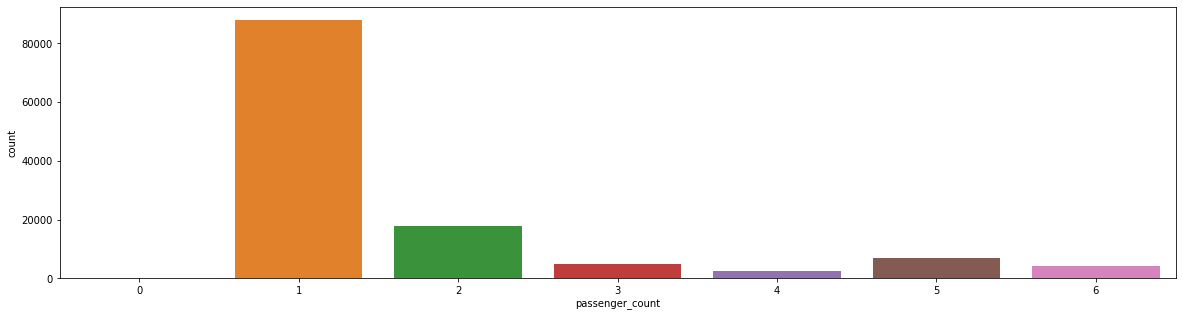

In [ ]:
plt.figure(figsize=(20,5))
sns.countplot(trips.passenger_count)
plt.show()

In [ ]:
trips.passenger_count.value_counts(normalize=True)

1    0.706593
2    0.143048
5    0.056363
3    0.040229
6    0.033842
4    0.019902
0    0.000024
Name: passenger_count, dtype: float64

**Write your answers here: the distribution of passenger count follows a normal distribution**


### **Question 2.3 Plotting countplot for pickup_neighborhood and dropoff_neighborhood (2 Marks)**

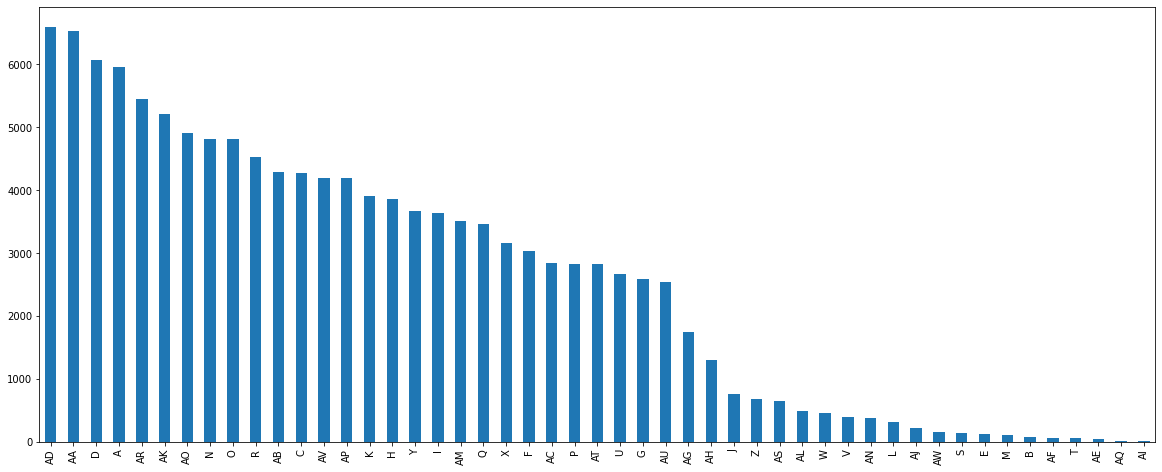

In [ ]:
trips.pickup_neighborhood.value_counts().plot(kind='bar' ,figsize=(20,8))

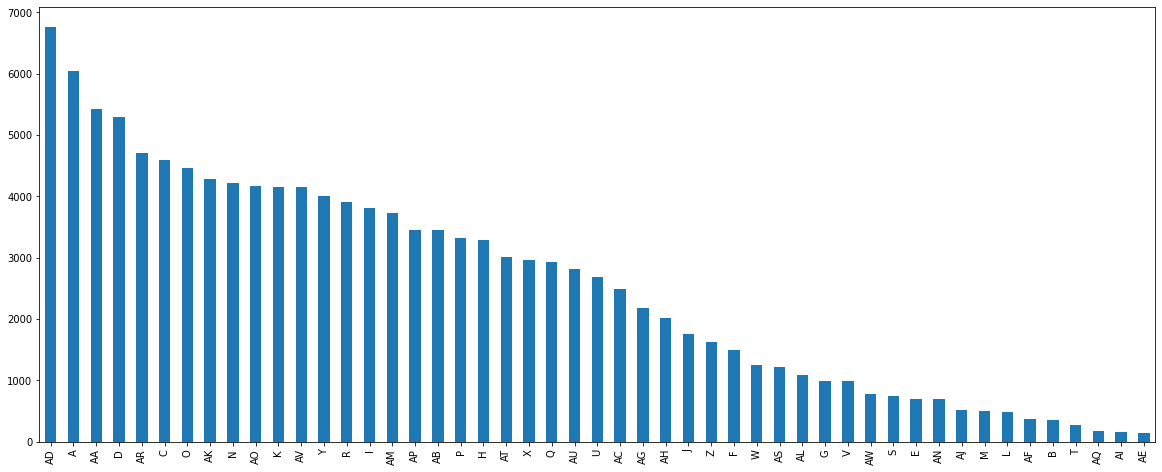

In [ ]:

trips.dropoff_neighborhood.value_counts().plot(kind='bar' ,figsize=(20,8))

**Write your answers here: AD and A has the most pickups and dropoffs. AE and AI has the least amount**

## **Bivariate analysis**

#### **Plot a scatter plot for trip distance and trip duration**

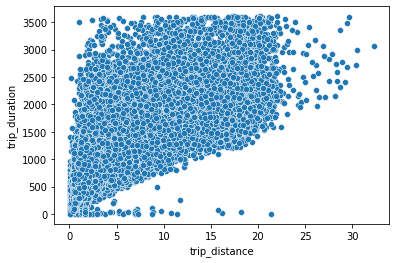

In [ ]:
sns.scatterplot(trips['trip_distance'],trips['trip_duration'])

- There is some positive correlation between trip_distance and trip_duration.

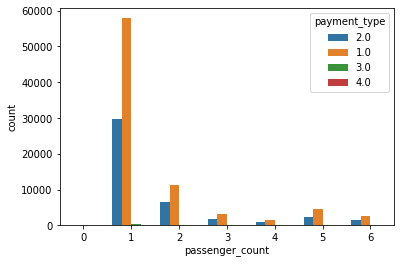

In [ ]:
sns.countplot(trips['passenger_count'],hue=trips['payment_type'])

- There is no such specific pattern can be observed.

## **Step 2: Prepare the Data**

Lets create entities and relationships. The three entities in this data are 
* trips 
* pickup_neighborhoods
* dropoff_neighborhoods

This data has the following relationships
* pickup_neighborhoods --> trips (one neighborhood can have multiple trips that start in it. This means pickup_neighborhoods is the ``parent_entity`` and trips is the child entity)
* dropoff_neighborhoods --> trips (one neighborhood can have multiple trips that end in it. This means dropoff_neighborhoods is the ``parent_entity`` and trips is the child entity)

In [featuretools](https://featuretools.alteryx.com/en/v0.27.0/getting_started/getting_started_index.html) (automated feature engineering software package), we specify the list of entities and relationships as follows: 


### **Question 3: Define entities and relationships for the Deep Feature Synthesis (2 Marks)**

In [ ]:

entities = {
        "trips": (trips, "id", 'pickup_datetime' ),
        "pickup_neighborhoods": (pickup_neighborhoods, "neighborhood_id"),
        "dropoff_neighborhoods": (dropoff_neighborhoods, "neighborhood_id"),
        }

relationships = [("pickup_neighborhoods", "neighborhood_id", "trips", "pickup_neighborhood"),
                 ("dropoff_neighborhoods", "neighborhood_id", "trips", "dropoff_neighborhood")]

Next, we specify the cutoff time for each instance of the target_entity, in this case ``trips``.This timestamp represents the last time data can be used for calculating features by DFS. In this scenario, that would be the pickup time because we would like to make the duration prediction using data before the trip starts. 

For the purposes of the case study, we choose to only select trips that started after **January 12th, 2016**. 

In [ ]:
cutoff_time = trips[['id', 'pickup_datetime']]
cutoff_time = cutoff_time[cutoff_time['pickup_datetime'] > "2016-01-12"]
preview(cutoff_time, 10)

,id,pickup_datetime
54031,56311,2016-01-12 00:00:25
100975,105349,2016-01-20 18:38:31
100976,105350,2016-01-20 18:38:51
100977,105351,2016-01-20 18:38:54
100978,105352,2016-01-20 18:39:07
100979,105353,2016-01-20 18:39:14
100980,105354,2016-01-20 18:39:23
100981,105355,2016-01-20 18:39:29
100982,105356,2016-01-20 18:39:34
100983,105357,2016-01-20 18:39:34


## **Step 3: Create baseline features using Deep Feature Synthesis**

Instead of manually creating features, such as "month of pickup datetime", we can let DFS come up with them automatically. It does this by 
* interpreting the variable types of the columns e.g categorical, numeric and others 
* matching the columns to the primitives that can be applied to their variable types
* creating features based on these matches

**Create transform features using transform primitives**

As we described in the video, features fall into two major categories, ``transform`` and ``aggregate``. In featureools, we can create transform features by specifying ``transform`` primitives. Below we specify a ``transform`` primitive called ``weekend`` and here is what it does:

* It can be applied to any ``datetime`` column in the data. 
* For each entry in the column, it assess if it is a ``weekend`` and returns a boolean. 

In this specific data, there are two ``datetime`` columns ``pickup_datetime`` and ``dropoff_datetime``. The tool automatically creates features using the primitive and these two columns as shown below. 

## **Question 4: Creating a baseline model with only 1 transform primitive (10 Marks)**

### **Question: 4.1 Define transform primitive for weekend and define features using dfs?** 

In [ ]:
trans_primitives = [IsWeekend]


features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

*If you're interested about parameters to DFS such as `ignore_variables`, you can learn more about these parameters [here](https://featuretools.alteryx.com/en/v0.27.0/getting_started/getting_started_index.html)*

Here are the features created.

In [ ]:
print ("Number of features: %d" % len(features))
features

Number of features: 12


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]


Now let's compute the features. 

### **Question: 4.2 Compute features and define feature matrix**

In [ ]:
def compute_features(features, cutoff_time):
    # Shuffle so we don't see encoded features in the front or backs

    np.random.shuffle(features)
    feature_matrix = ft.calculate_feature_matrix(features,
                                                 cutoff_time=cutoff_time,
                                                 approximate='36d',
                                                 verbose=True,entities=entities, relationships=relationships)
    print("Finishing computing...")
    feature_matrix, features = ft.encode_features(feature_matrix, features,
                                                  to_encode=["pickup_neighborhood", "dropoff_neighborhood"],
                                                  include_unknown=False)
    return feature_matrix

In [ ]:
feature_matrix1 = compute_features(features,cutoff_time)

Elapsed: 00:01 | Progress: 100%|██████████
Finishing computing...


In [ ]:
preview(feature_matrix1, 5)

,passenger_count,pickup_neighborhood = AD,pickup_neighborhood = AA,pickup_neighborhood = A,pickup_neighborhood = D,pickup_neighborhood = AR,pickup_neighborhood = AK,pickup_neighborhood = AO,pickup_neighborhood = N,pickup_neighborhood = O,...,dropoff_neighborhood = AK,dropoff_neighborhood = N,dropoff_neighborhood = K,pickup_neighborhoods.longitude,IS_WEEKEND(pickup_datetime),trip_distance,trip_duration,dropoff_neighborhoods.latitude,pickup_neighborhoods.latitude,vendor_id
id,,,,,,,,,,,,,,,,,,,,,
56311,1,False,False,False,False,False,False,False,False,False,...,False,False,False,-73.987205,False,1.61,645.0,40.721435,40.720245,2
105349,1,False,False,True,False,False,False,False,False,False,...,False,True,False,-73.975899,False,0.60,349.0,40.756598,40.761492,1
105350,2,False,False,False,False,False,False,True,False,False,...,False,False,False,-73.985336,False,1.10,942.0,40.750179,40.747126,1
105351,1,False,False,False,False,False,False,False,False,False,...,False,False,False,-73.995736,False,1.30,845.0,40.761492,40.761087,1
105352,4,False,False,False,False,False,False,False,False,False,...,False,False,False,-73.982322,False,1.35,366.0,40.793597,40.776270,2


In [ ]:
feature_matrix1.shape

(70431, 30)

### **Model Building**
------------------

To build a model, we
* Separate the data into a portion for ``training`` (75% in this case) and a portion for ``testing`` 
* Get the log of the trip duration so that a more linear relationship can be found.
* Train a model using a ``Linear Regression, Decision Tree and Random Forest model``

#### **Transforming the duration variable on sqrt and log**



(array([  543.,  4979., 23195., 34064., 28913., 17425.,  8675.,  4003.,
         1802.,   863.]),
 array([ 1.        ,  6.90416522, 12.80833044, 18.71249566, 24.61666088,
        30.5208261 , 36.42499133, 42.32915655, 48.23332177, 54.13748699,
        60.04165221]),
 <a list of 10 Patch objects>)

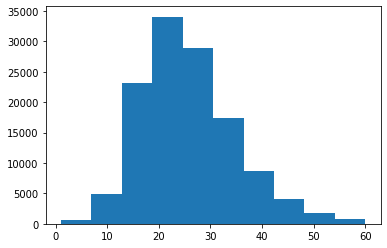

In [ ]:
plt.hist(np.sqrt(trips['trip_duration']))

(array([3.2000e+01, 6.9000e+01, 7.2000e+01, 1.7800e+02, 3.5300e+02,
        2.7720e+03, 1.9225e+04, 5.0476e+04, 4.1785e+04, 9.5000e+03]),
 array([0.        , 0.8190077 , 1.63801541, 2.45702311, 3.27603082,
        4.09503852, 4.91404623, 5.73305393, 6.55206164, 7.37106934,
        8.19007705]),
 <a list of 10 Patch objects>)

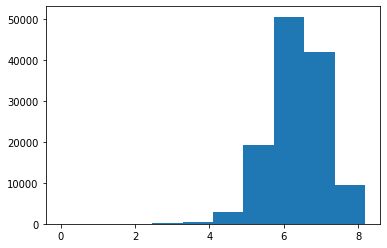

In [ ]:
plt.hist(np.log(trips['trip_duration']))

- We can clearly see that the sqrt transformation is giving nearly normal distribution, there for we can choose the sqrt transformation on the dependent(trip_duration) variable.

#### **Splitting the data into train and test**

In [ ]:
# Separates the whole feature matrix into train data feature matrix, train data labels, and test data feature matrix 
X_train, y_train, X_test, y_test = get_train_test_fm(feature_matrix1,.75)
y_train = np.sqrt(y_train)
y_test = np.sqrt(y_test)

**Defining function for to check the performance of the model.**

In [ ]:
# RMSE
def rmse(predictions, targets):
    return np.sqrt(((targets - predictions) ** 2).mean())

# MAE
def mae(predictions, targets):
    return np.mean(np.abs((targets - predictions)))


# Model Performance on test and train data
def model_pref(model, x_train, x_test, y_train,y_test):

    # Insample Prediction
    y_pred_train = model.predict(x_train)
    y_observed_train = y_train

    # Prediction on test data
    y_pred_test = model.predict(x_test)
    y_observed_test = y_test

    print(
        pd.DataFrame(
            {
                "Data": ["Train", "Test"],
                'RSquared':
                    [r2_score(y_observed_train,y_pred_train),
                    r2_score(y_observed_test,y_pred_test )
                    ],
                "RMSE": [
                    rmse(y_pred_train, y_observed_train),
                    rmse(y_pred_test, y_observed_test),
                ],
                "MAE": [
                    mae(y_pred_train, y_observed_train),
                    mae(y_pred_test, y_observed_test),
                ],
            }
        )
    )

### **Question 4.3 Build Linear regression using only weekend transform primitive**

In [ ]:
# Defining the model
lr1=LinearRegression()

# Fitting the model
lr1.fit(X_train,y_train)


LinearRegression()

#### **Check the performance of the model**

In [ ]:
model_pref(lr1, X_train, X_test,y_train,y_test)  

    Data  RSquared      RMSE       MAE
0  Train  0.590797  5.802519  4.500993
1   Test  0.472967  7.148916  5.338872


**Write your answers here:
Model is giving only 0.59 Rsquared, with RSME of 5.80 and MAE of ~4.50.
Model is slightly overfitting.**

### **Question 4.4 Building decision tree using only weekend transform primitive**

In [ ]:
# Define the model
dt=DecisionTreeRegressor()

# Fit the model
dt.fit(X_train,y_train)

DecisionTreeRegressor()

#### **Check the performance of the model**

In [ ]:
model_pref(dt, X_train, X_test,y_train,y_test)  

    Data  RSquared      RMSE       MAE
0  Train  0.972363  1.507969  0.554785
1   Test  0.497729  6.978950  5.183201


**Write your answers here:
The model is overfitting a lot, with train R2 as 0.97 while test R2 as 0.49
This generally happens in decision tree, one solution for this is to Prune the decision tree, let's try pruning and see if the performance improves.**


### **Question 4.5 Building Pruned decision tree using only weekend transform primitive**

In [ ]:
# Define the model

# Use max_depth=7
dt_pruned=DecisionTreeRegressor(max_depth=7)

# Fit the model
dt_pruned.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=7)

#### **Check the performance of the model**

In [ ]:
model_pref(dt_pruned, X_train, X_test,y_train,y_test)   

    Data  RSquared      RMSE       MAE
0  Train  0.743405  4.594846  3.504844
1   Test  0.636437  5.937601  4.261875


**Write your answers here:
The pruned model is performing better that both baseline decision tree and linear regression, with R2 as ~.63.**

### **Question 4.6 Building Random Forest using only weekend transform primitive**

In [ ]:
# Define the model

# using (n_estimators=60,max_depth=7)
rf=RandomForestRegressor(n_estimators=60,max_depth=7)

In [ ]:
# Fit the model

rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=7, n_estimators=60)

#### **Check the performance of the model**

In [ ]:

model_pref(rf, X_train, X_test,y_train,y_test)

    Data  RSquared      RMSE       MAE
0  Train  0.752032  4.516946  3.449458
1   Test  0.646628  5.853793  4.192629


**Write your answers here:
The score for the model with only 1 transform primitive is ~64%.
This model is performing little better than pruned decision tree model.
Model is slightly overfitting.**


### **Step 4: Adding more Transform Primitives and creating new model**

* Add ``Minute``, ``Hour``, ``Month``, ``Weekday`` , etc primitives
* All these transform primitives apply to ``datetime`` columns

## **Question 5: Create models with more transform primitives (10 Marks)**



### **Question 5.1 Define more transform primitives and define features using dfs?**

In [ ]:
trans_primitives = [Minute, Hour, Day, Month, Weekday, IsWeekend]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [ ]:
print ("Number of features: %d" % len(features))
features

Number of features: 17


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

Now let's compute the features. 

### **Question 5.2 Compute features and define feature matrix**

In [ ]:
feature_matrix2 = compute_features(features,cutoff_time)

Elapsed: 00:00 | Progress: 100%|██████████
Finishing computing...


In [ ]:
feature_matrix2.shape

(70431, 35)

In [ ]:
feature_matrix2.head()

,pickup_neighborhoods.latitude,HOUR(pickup_datetime),pickup_neighborhoods.longitude,IS_WEEKEND(pickup_datetime),passenger_count,dropoff_neighborhoods.longitude,DAY(pickup_datetime),trip_duration,dropoff_neighborhood = AD,dropoff_neighborhood = A,...,pickup_neighborhood = AO,pickup_neighborhood = N,pickup_neighborhood = O,pickup_neighborhood = R,WEEKDAY(pickup_datetime),vendor_id,MINUTE(pickup_datetime),trip_distance,dropoff_neighborhoods.latitude,MONTH(pickup_datetime)
id,,,,,,,,,,,,,,,,,,,,,
56311,40.720245,0,-73.987205,False,1,-73.998366,12,645.0,False,False,...,False,False,False,False,1,2,0,1.61,40.721435,1
56312,40.646194,0,-73.785073,False,1,-73.954298,12,1270.0,False,False,...,False,False,False,False,1,2,2,16.15,40.715828,1
56313,40.818445,0,-73.948046,False,1,-73.948046,12,207.0,False,False,...,False,False,False,False,1,1,2,0.80,40.818445,1
56314,40.729652,0,-73.991595,False,5,-73.977943,12,214.0,False,False,...,False,False,False,False,1,2,2,1.33,40.742531,1
56315,40.793597,0,-73.969822,False,1,-73.948046,12,570.0,False,False,...,False,False,False,False,1,2,3,2.35,40.818445,1


**Build the new models more transform features**

In [ ]:
# Separates the whole feature matrix into train data feature matrix,train data labels, and test data feature matrix 
X_train2, y_train2, X_test2, y_test2 = get_train_test_fm(feature_matrix2,.75)
y_train2 = np.sqrt(y_train2)
y_test2 = np.sqrt(y_test2)

### **Question 5.3 Building Linear regression using more transform primitive**

In [ ]:
# Defining the model
lr2=LinearRegression()

# Fitting the model
lr2.fit(X_train2,y_train2)

LinearRegression()

#### **Check the performance of the model**

In [ ]:
model_pref(lr2, X_train2, X_test2,y_train2,y_test2)  

    Data  RSquared      RMSE       MAE
0  Train  0.595220  5.771072  4.469631
1   Test  0.475803  7.129655  5.358349


**Write your answers here:
Model is giving 0.48 Rsquared, with RSME of 5.77 and MAE of ~4.47.
Model performance has not improved much from the last model by adding more transform primitives
Model is not overfitting, and giving generalized results.**

### **Question 5.4 Building Decision tree using more transform primitive**

In [ ]:
# Define the model
dt2=DecisionTreeRegressor()

# Fit the model
dt2.fit(X_train2,y_train2)

DecisionTreeRegressor()

#### **Check the performance of the model**

In [ ]:
model_pref(dt2, X_train2, X_test2,y_train2,y_test2)  

    Data  RSquared      RMSE       MAE
0  Train  0.999996  0.017617  0.000108
1   Test  0.553459  6.580390  4.891497


**Write your answers here:
The model is overfitting a lot, with train R2 as 0.999 while test R2 as 0.55.
This generally happens in decision tree, one solution for this is to Prune the decision tree, let's try pruning and see if the performance improves.**

### **Question 5.5 Building Pruned Decision tree using more transform primitive**

In [ ]:
# Define the model

# Use max_depth=7
dt_pruned2=DecisionTreeRegressor(max_depth=4)

# Fit the model
dt_pruned2.fit(X_train2,y_train2)

DecisionTreeRegressor(max_depth=4)

#### **Check the performance of the model**

In [ ]:
model_pref(dt_pruned2, X_train2, X_test2,y_train2,y_test2)  

    Data  RSquared      RMSE       MAE
0  Train  0.726084  4.747401  3.612134
1   Test  0.624760  6.032200  4.349511


**Write your answers here: 
Model is giving ~0.62 Rsquared, with RSME of 4.74 and MAE of ~3.61.
Model performance has improved by adding more transform features.
Model is slightly overfitting.**

### **Question 5.6 Building Random Forest using more transform primitive**

In [ ]:
# Fit the model

# Using (n_estimators=60,max_depth=7)

rf2=RandomForestRegressor(n_estimators=60,max_depth=7)

# Fit the model

rf2.fit(X_train2,y_train2)

RandomForestRegressor(max_depth=7, n_estimators=60)

#### **Check the performance of the model**

In [ ]:
model_pref(rf2, X_train2, X_test2,y_train2,y_test2)  

    Data  RSquared      RMSE       MAE
0  Train  0.795274  4.104251  3.067049
1   Test  0.688766  5.493700  3.908478


**Write your answers here: 
The score for the model with more transform primitive is ~68%.
As compared to previous model, the score has improved significantly.**


### **Question: 5.7 Comment on how the modeling accuracy differs when including more transform features.**

**Write your answers here: modelling accuracy tends to improve in general, when including more features.

However, there is a risk of overfitting.**

### **Step 5: Add Aggregation Primitives**

Now let's add aggregation primitives. These primitives will generate features for the parent entities ``pickup_neighborhoods``, and ``dropoff_neighborhood`` and then add them to the trips entity, which is the entity for which we are trying to make prediction.

## **Question 6: Create a Models with transform and aggregate primitive. (10 Marks)**


###**6.1 Define more transform and aggregate primitive and define features using dfs?**

In [ ]:
trans_primitives = [Minute, Hour, Day, Month, Weekday, IsWeekend]
aggregation_primitives = [Count, Sum, Mean, Median, Std, Max, Min]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=aggregation_primitives,
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [ ]:
print ("Number of features: %d" % len(features))
features

Number of features: 55


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>,
 <Feature: pickup_neighborhoods.COUNT(trips)>,
 <Feature: pickup_neighborhoods.MAX(trips.passenger_count)>,
 <Feature: pickup_neighborhoods.MAX(trips.trip_distance)>,
 <Feature: pickup_neighborhoods.MAX(trips.trip_duration)>,
 <Feature: pickup_neighborhoods.MEAN(trips.passenger_count)>,
 <Feature: pickup_neighborhoods.MEAN(trips.trip_distance)>,
 <Feature: pickup_neighborhoods.MEAN(trips.trip_duration

### **Question: 6.2 Compute features and define feature matrix**

In [ ]:
feature_matrix3 = compute_features(features, cutoff_time)

Elapsed: 00:01 | Progress: 100%|██████████
Finishing computing...


In [ ]:
feature_matrix3.head()

,HOUR(pickup_datetime),dropoff_neighborhoods.MEAN(trips.trip_duration),MONTH(pickup_datetime),dropoff_neighborhoods.STD(trips.trip_distance),pickup_neighborhoods.MEAN(trips.trip_distance),pickup_neighborhoods.SUM(trips.passenger_count),IS_WEEKEND(pickup_datetime),pickup_neighborhoods.COUNT(trips),pickup_neighborhoods.SUM(trips.trip_duration),pickup_neighborhoods.MAX(trips.trip_distance),...,dropoff_neighborhoods.STD(trips.passenger_count),dropoff_neighborhoods.MIN(trips.trip_duration),dropoff_neighborhoods.MAX(trips.passenger_count),trip_distance,pickup_neighborhoods.longitude,dropoff_neighborhoods.MEDIAN(trips.trip_duration),dropoff_neighborhoods.MEDIAN(trips.passenger_count),pickup_neighborhoods.MAX(trips.passenger_count),dropoff_neighborhoods.MAX(trips.trip_duration),dropoff_neighborhoods.MAX(trips.trip_distance)
id,,,,,,,,,,,,,,,,,,,,,
56311,0,776.627978,1,2.776681,3.008120,2219,False,1298,965650.0,18.57,...,1.303984,1.0,6,1.61,-73.987205,668.0,1.0,6,3572.0,20.54
56312,0,1036.722148,1,3.831003,15.573704,2239,False,1250,2581191.0,32.30,...,1.335982,4.0,6,16.15,-73.785073,942.0,1.0,6,3526.0,19.00
56313,0,933.914230,1,3.706270,2.867798,390,False,218,146585.0,18.50,...,1.289944,6.0,6,0.80,-73.948046,898.0,1.0,6,3312.0,25.30
56314,0,570.183240,1,2.399307,2.285062,2838,False,1703,1156824.0,18.30,...,1.375904,9.0,6,1.33,-73.991595,474.0,1.0,6,3581.0,19.16
56315,0,933.914230,1,3.706270,2.146973,1897,False,1176,721542.0,20.30,...,1.289944,6.0,6,2.35,-73.969822,898.0,1.0,6,3312.0,25.30


**Build the new models more transform and aggregate features**

In [ ]:
# Separates the whole feature matrix into train data feature matrix,train data labels, and test data feature matrix 
X_train3, y_train3, X_test3, y_test3 = get_train_test_fm(feature_matrix3,.75)
y_train3 = np.sqrt(y_train3)
y_test3 = np.sqrt(y_test3)

### **Question 6.3 Building  Linear regression model with transform and aggregate primitive.**

In [ ]:
# Defining the model
lr3=LinearRegression()

# Fitting the model
lr3.fit(X_train3,y_train3)

LinearRegression()

#### **Check the performance of the model**

In [ ]:
model_pref(lr3, X_train3, X_test3,y_train3,y_test3)  

    Data  RSquared      RMSE       MAE
0  Train  0.618912  5.599634  4.313373
1   Test  0.502523  6.945563  5.174276


**Write your answers here: 
Model is giving only 0.50 Rsquared, with RSME of 5.6 and MAE of ~4.3
Model is not overfitting, and giving generalized results.**

### **Question 6.4 Building  Decision tree with transform and aggregate primitive.**

In [ ]:
# Define the model
dt3=DecisionTreeRegressor()

# Fit the model

dt3.fit(X_train3,y_train3)

DecisionTreeRegressor()

#### **Check the performance of the model**

In [ ]:
model_pref(dt3, X_train3, X_test3,y_train3,y_test3)  

    Data  RSquared      RMSE       MAE
0  Train  0.999996  0.017617  0.000108
1   Test  0.549236  6.611431  4.886171


**Write your answers here:
The model is overfitting a lot, with train R2 as 0.999 while test R2 as 0.54
This generally happens in decision tree, one solution for this is to Prune the decision tree, let's try pruning and see if the performance improves.**

### **Question 6.5 Building  Pruned Decision tree with transform and aggregate primitive.**

In [ ]:
# Define the model

# Use max_depth=7
dt_pruned3=DecisionTreeRegressor(max_depth=7)

# Fit the model
dt_pruned3.fit(X_train3,y_train3)

DecisionTreeRegressor(max_depth=7)

#### **Check the performance of the model**

In [ ]:
model_pref(dt_pruned3, X_train3, X_test3,y_train3,y_test3)  

    Data  RSquared      RMSE       MAE
0  Train  0.784331  4.212509  3.157483
1   Test  0.676993  5.596638  4.003587


**Write your answers here:
Model is giving ~0.67 Rsquared, with RSME of 4.2 and MAE of ~3.2.
The model performance has not improved by adding aggregate primitives.
Model is overfitting, and is not giving generalized results.**


### **Question 6.6 Building  Random Forest with transform and aggregate primitive.**

In [ ]:
# Fit the model


# Using (n_estimators=60,max_depth=7)

rf3=RandomForestRegressor(n_estimators=60,max_depth=7)

# Fit the model


rf3.fit(X_train3,y_train3)

RandomForestRegressor(max_depth=7, n_estimators=60)

#### **Check the performance of the model**

In [ ]:
model_pref(rf3, X_train3, X_test3,y_train3,y_test3)  

    Data  RSquared      RMSE       MAE
0  Train  0.798210  4.074715  3.048134
1   Test  0.691466  5.469812  3.891186


**Write your answers here:
The model Performance has improved from ~0.69 by the addition of transform and aggregation features.**



### **Question 6.7 How do these aggregate transforms impact performance? How do they impact training time?**

**Write your answers here:
The modeling score has not improved much after adding aggregate transforms, and also the training time was also increased by a significant amount, implies that adding more features is always not very effective.**

**Based on the above 3 models, we can make predictions using our model2, as it is giving almost same accuracy as model3 and also the training time is not that large as compared to model3**

In [ ]:
y_pred = rf2.predict(X_test2)
y_pred = y_pred**2 # Undo the sqrt we took earlier
y_pred[5:]

array([ 734.13381542,  740.54830937,  180.67718892, ...,  400.02401148,
        401.29170272, 2356.39129545])

### **Question 7: What are some important features based on `model2` and how can they affect the duration of the rides? (3 Marks)**

In [ ]:
feature_importances(rf2, feature_matrix2.drop(['trip_duration'],axis=1).columns, n=10)

1: Feature: trip_distance, 0.914
2: Feature: HOUR(pickup_datetime), 0.056
3: Feature: dropoff_neighborhoods.latitude, 0.009
4: Feature: DAY(pickup_datetime), 0.006
5: Feature: WEEKDAY(pickup_datetime), 0.005
6: Feature: pickup_neighborhoods.longitude, 0.003
7: Feature: IS_WEEKEND(pickup_datetime), 0.002
8: Feature: payment_type, 0.002
9: Feature: dropoff_neighborhoods.longitude, 0.002
10: Feature: pickup_neighborhoods.latitude, 0.001


**Write your answers here:
Trip_Distance is the most important feature, which implies that the longer the trip is the longer duration of the trip is.
Features like dropoff_neighborhoods.longitude, pickup_neighborhoods.longitude, dropoff_neighborhoods.latitude,pickup_neighborhoods.latitude signifies that trip duration is impacted by pickup and dropoff locations.**

In [ ]:
%%shell
jupyter nbconvert --to html /content/ManishSeal_PredictiveAnalysis.ipynb

[NbConvertApp] Converting notebook /content/ManishSeal_PredictiveAnalysis.ipynb to html
/usr/local/lib/python3.7/dist-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.colab-display-data+json']) is not able to be represented.
  mimetypes=output.keys())
[NbConvertApp] Writing 714731 bytes to /content/ManishSeal_PredictiveAnalysis.html
